In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random 
import cv2
from data_utils import splite_train_valid, DataGenerator
from model import resnet_18
import tensorflow as tf
import shutil
import tensorflow_addons as tfa


2022-11-26 17:53:44.144926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 17:53:44.730982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-11-26 17:53:44.731032: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-11-26 17:53:44.731042: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
for f in os.listdir('dataset/backup/'):
    shutil.copy('dataset/backup/'+f, 'dataset/digital_3d_processed/')
shutil.rmtree('Train')
shutil.rmtree('Valid')

In [3]:

os.environ['CUDA_VISIBLE_DEVICES'] = "0"


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
dataset_dir = 'dataset/digital_3d_processed/'
train_list,valid_list = splite_train_valid(dataset_dir, 0.7)

/home/dengli/anaconda3/envs/digital3D/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(64, 256, 256, 1) (64, 1)
300


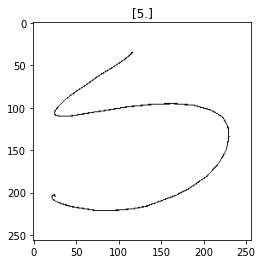

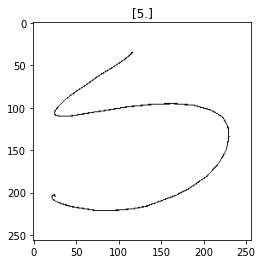

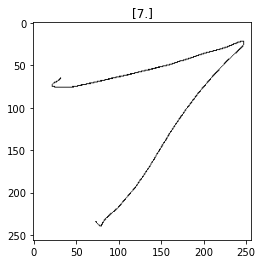

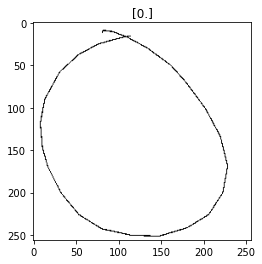

In [6]:
train_datagen = DataGenerator(train_list)
x, y = train_datagen[0]
for i in range(3):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(x[i] ,cmap='gray')
    ax.set_title(y[i])
print(x.shape,y.shape)

valid_datagen = DataGenerator(valid_list,mode='testing')
x,y = valid_datagen[0]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(x[0] ,cmap='gray')
ax.set_title(y[0])
print(len(valid_datagen))

In [7]:
train_datagen = DataGenerator(train_list)
x, y = train_datagen[0]

In [10]:
num_classes = 10
input_shape = (256, 256, 1)

#data_augmentation = tf.keras.Sequential([tf.keras.layers.Normalization()])

# Setting the state of the normalization layer.
#data_augmentation.layers[0].adapt(x)

def create_encoder():
    
    resnet = resnet_18(input_shape=input_shape)


    inputs = tf.keras.Input(shape=input_shape)
    #augmented = data_augmentation(inputs)
    outputs = resnet(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


#encoder = create_encoder()
#encoder.summary()
input_shape = (256, 256, 1)
learning_rate = 0.001
batch_size = 64
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05


In [11]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = tf.keras.Input(shape=input_shape)
    features = encoder(inputs)
    #features = tf.keras.layers.Dropout(dropout_rate)(features)
    #features = tf.keras.layers.Dense(hidden_units, activation="relu")(features)
    #features = tf.keras.layers.Dropout(dropout_rate)(features)
    #outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(features)

    model = tf.keras.Model(inputs=inputs, outputs=features, name="cifar10-classifier")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


In [12]:
model = resnet_18(input_shape=input_shape,learning_rate=learning_rate,dropout_rate=dropout_rate,num_class=num_classes,num_hidden=hidden_units)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1600        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [45]:


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)
]



history = model.fit_generator(train_datagen,epochs=num_epochs,steps_per_epoch=100,validation_data=valid_datagen,validation_steps=200,verbose=1,callbacks=my_callbacks)


Epoch 1/50


/home/dengli/anaconda3/envs/digital3D/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


100/100 [==============================] - 31s 255ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8698 - val_loss: 6.3852 - val_sparse_categorical_accuracy: 0.1850 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 16s 158ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9923 - val_loss: 23.5860 - val_sparse_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 5s 49ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9862 - val_loss: 21.2023 - val_sparse_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 5s 49ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9930 - val_loss: 41.2479 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 5s 49ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9953 - val_loss: 76.3226 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
100/100 [=====

In [14]:
classifier = resnet_18(input_shape=input_shape,learning_rate=learning_rate,dropout_rate=dropout_rate,num_class=num_classes,num_hidden=hidden_units)
classifier.load_weights('model.24-0.06.h5')

corrects = 0
valid_datagen = DataGenerator(valid_list,mode='testing')
for i in range(len(valid_datagen)):
    x,y = valid_datagen[i]
    pred = np.argmax(classifier.predict(x,verbose=0))
    if pred == y:
        corrects = corrects + 1
        
print('Accuracy {:.3f} %'.format((corrects/len(valid_datagen))*100))
classifier.save('model.h5')

Accuracy 99.333 %


In [14]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)
]

encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit_generator(train_datagen,epochs=num_epochs,steps_per_epoch=100,validation_data=valid_datagen,validation_steps=200,verbose=1,callbacks=my_callbacks)


Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 cifar10-encoder (Functional  (None, 256)              1575488   
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                

/home/dengli/anaconda3/envs/digital3D/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == "":


100/100 [==============================] - 9s 46ms/step - loss: 1.1150 - sparse_categorical_accuracy: 0.6578 - val_loss: 6.9232 - val_sparse_categorical_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 4s 44ms/step - loss: 0.2618 - sparse_categorical_accuracy: 0.9475 - val_loss: 11.5234 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0783 - sparse_categorical_accuracy: 0.9920 - val_loss: 9.0994 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - 4s 45ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9983 - val_loss: 8.5904 - val_sparse_categorical_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 5/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9991 - val_loss: 9.0561 - val_sparse_categorical_accuracy: 0.1200 - lr: 1.0000e-04
Epoch 6/50
1

In [16]:
classifier = create_classifier(encoder)
classifier.load_weights('model.12-0.29.h5')

corrects = 0
valid_datagen = DataGenerator(valid_list,mode='testing')
for i in range(len(valid_datagen)):
    x,y = valid_datagen[i]
    pred = np.argmax(classifier.predict(x,verbose=0))
    if pred == y:
        corrects = corrects + 1
        
print('Accuracy {:.3f} %'.format((corrects/len(valid_datagen))*100))
classifier.save('model.h5')

Accuracy 90.333 %


In [17]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = tf.keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = tf.keras.layers.Dense(projection_units, activation="relu")(features)
    model = tf.keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model


In [18]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001)
]

encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = classifier.fit_generator(train_datagen,epochs=num_epochs,steps_per_epoch=100,validation_data=valid_datagen,validation_steps=200,verbose=1,callbacks=my_callbacks)


Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 cifar10-encoder (Functional  (None, 256)              1575491   
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
Total params: 1,608,387
Trainable params: 1,605,504
Non-trainable params: 2,883
_________________________________________________________________
Epoch 1/50


/home/dengli/anaconda3/envs/digital3D/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


100/100 [==============================] - 9s 48ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9903 - val_loss: 3.5917 - val_sparse_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9942 - val_loss: 10.5752 - val_sparse_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.8750 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9991 - val_loss: 1.1339 - val_sparse_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 5s 46ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.4355 - val_sparse_categorical_accuracy: 0.9300 - lr: 0.0010
Epoch 6/50
100/100 [====================

In [19]:
classifier = create_classifier(encoder)
classifier.load_weights('model.19-0.24.h5')

corrects = 0
valid_datagen = DataGenerator(valid_list,mode='testing')
for i in range(len(valid_datagen)):
    x,y = valid_datagen[i]
    pred = np.argmax(classifier.predict(x,verbose=0))
    if pred == y:
        corrects = corrects + 1
        
print('Accuracy {:.3f} %'.format((corrects/len(valid_datagen))*100))

Accuracy 96.000 %


In [15]:
classifier = create_classifier(encoder, trainable=False)
history = classifier.fit_generator(train_datagen,epochs=num_epochs,steps_per_epoch=100,validation_data=valid_datagen,validation_steps=200,verbose=1,callbacks=my_callbacks)


Epoch 1/50


/home/dengli/anaconda3/envs/digital3D/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


100/100 [==============================] - 3s 18ms/step - loss: 0.2283 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.1869 - val_sparse_categorical_accuracy: 0.9400 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - loss: 0.0102 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1735 - val_sparse_categorical_accuracy: 0.9600 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0056 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1577 - val_sparse_categorical_accuracy: 0.9400 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0036 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2043 - val_sparse_categorical_accuracy: 0.9450 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1988 - val_sparse_categorical_accuracy: 0.9450 - lr: 0.0010
Epoch 6/50
100/100 [=====================

In [16]:
classifier = create_classifier(encoder, trainable=False)
classifier.load_weights('model.03-0.16.h5')

corrects = 0
valid_datagen = DataGenerator(valid_list,mode='testing')
for i in range(len(valid_datagen)):
    x,y = valid_datagen[i]
    pred = np.argmax(classifier.predict(x,verbose=0))
    if pred == y:
        corrects = corrects + 1
        
print('Accuracy {:.3f} %'.format((corrects/len(valid_datagen))*100))

Accuracy 94.333 %
